In [58]:
%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import optuna
import xgboost as xgb
import colorsys
from sklearn.model_selection import train_test_split
from matplotlib.ticker import ScalarFormatter
from sklearn.decomposition import PCA
# from my_func import corr_plot_quads
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import shap
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [2]:
def myplots(axes,y_true_list, y_pred_list,var_list, title_str_list,region):
    fs = 14
    color_list = ["blue","orange"]
    for i in range(len(axes)):
        axes[i].scatter(y_true_list[i], y_pred_list[i], alpha = 0.6, c = color_list[i])
        axes[i].plot(region,region, 'k--', alpha=0.75, zorder=0)
        # axes[i].errorbar(y_true_list[i],y_pred_list[i], yerr = var_list[i], ms = 0, 
        #          ls = '', capsize = 2, alpha = 0.6,
        #          color = 'gray', zorder = 0)
        axes[i].set_xlabel('Ground Truth '+ "num: %d"%len(y_true_list[i]), fontsize = fs)
        axes[i].set_ylabel('Prediction')
        axes[i].set_xlim(region)
        axes[i].set_ylim(region)
        rmse = RMSE(y_true_list[i],y_pred_list[i])
        title = title_str_list[i] + " (RMSE = %.4f, r2: %.4f)"%(rmse, r2_score(y_true_list[i],y_pred_list[i]))
        axes[i].set_title(title, fontsize = fs)
        axes[i].grid(True, linestyle='-.')

def data_preparation(data, scaler, test_size=0.4, random_state=1):
    feature = data.values[:,:-1]
    target = data.values[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=test_size, random_state=random_state)
#     X_test = np.delete(X_test, 24, axis=0)
#     y_test = np.delete(y_test, 24, axis=0)
    if not scaler is None:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        dtrain = xgb.DMatrix(X_train_scaled, label=y_train,feature_names=list(data.columns[:-1]))
        dtest = xgb.DMatrix(X_test_scaled, label=y_test,feature_names=list(data.columns[:-1]))
        return data, X_train_scaled, X_test_scaled, y_train, y_test, dtrain, dtest
    else:
        dtrain = xgb.DMatrix(X_train, label=y_train,feature_names=list(data.columns[:-1]))
        dtest = xgb.DMatrix(X_test, label=y_test,feature_names=list(data.columns[:-1]))
    
        return data, X_train, X_test, y_train, y_test, dtrain, dtest

In [3]:
# mix & single
df = pd.read_excel("薄膜样本所有描述符计算结果.xlsx").iloc[list(range(35))+list(range(36,298)),6:]
df_feature = df.iloc[:, 1:]
#feature screening
feature_keeped_index = [0,1,3,6,7,8,9,10,16,17,18,22,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,46,48,57,58,59,60,61,66,68,75,76,78,79,\
                       84,94,95,99,100,101,102,103,105,106,112,114,117,118,122,123,124,159,169]
df_filter = df_feature.iloc[:,feature_keeped_index]

temp = pd.concat([df_filter,df['T80']],axis=1)
ml_data = temp#[(temp['Abs-T80'] <3000)]

In [32]:
# mix
df = pd.read_excel("薄膜样本所有描述符计算结果.xlsx").iloc[list(range(36,298)),6:]
df_feature = df.iloc[:, 1:]
#feature screening
feature_keeped_index = [0,1,3,6,7,8,9,10,16,17,18,22,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,46,48,57,58,59,60,61,66,68,75,76,78,79,\
                       84,94,95,99,100,101,102,103,105,106,112,114,117,118,122,123,124,159,169]
df_filter = df_feature.iloc[:,feature_keeped_index]

temp = pd.concat([df_filter,df['T80']],axis=1)
ml_data = temp#[(temp['Abs-T80'] <3000)]

In [3]:
# single
df = pd.read_excel("薄膜样本所有描述符计算结果.xlsx").iloc[list(range(35)),6:]
df_feature = df.iloc[:, 1:]
#feature screening
feature_keeped_index = [0,1,3,6,7,8,9,10,16,17,18,22,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,46,48,57,58,59,60,61,66,68,75,76,78,79,\
                       84,94,95,99,100,101,102,103,105,106,112,114,117,118,122,123,124,159,169]
df_filter = df_feature.iloc[:,feature_keeped_index]

temp = pd.concat([df_filter,df['T80']],axis=1)
ml_data = temp#[(temp['Abs-T80'] <3000)]

In [33]:
ml_data

,C atom,H atom,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,FpDensityMorgan1,FpDensityMorgan2,...,NumAromaticCarbocycles,NumAromaticRings,NumHeteroatoms,NumRotatableBonds,RingCount,MolLogP,MolMR,fr_benzene,fr_halogen,T80
36,7,10.500000,-3.254122,0.536663,242.575500,231.991500,242.491247,53.0,1.750000,2.544444,...,0.500000,1.000000,2.500000,2.5,1.000000,-2.848750,34.365100,0.500000,1.000000,876
37,7,10.000000,-3.284734,0.546317,251.570500,241.490500,251.486536,56.0,1.772727,2.535354,...,0.500000,1.000000,3.000000,2.5,1.000000,-2.779200,34.344100,0.500000,1.500000,1189
38,5.5,9.500000,-3.140278,0.540435,245.590000,236.014000,245.469457,51.0,2.000000,2.888889,...,0.000000,1.000000,3.000000,2.5,1.000000,-2.818000,33.303600,0.000000,1.000000,1367
39,7.5,11.500000,-3.308260,0.561362,257.588500,245.996500,257.496529,59.0,1.833333,2.652778,...,0.500000,1.000000,3.000000,3.5,1.000000,-2.844450,37.641100,0.500000,1.000000,1641
40,7,10.000000,-3.295788,0.546317,251.570500,241.490500,251.486536,56.0,1.863636,2.717172,...,0.500000,1.000000,3.000000,2.5,1.000000,-2.779200,34.344100,0.500000,1.500000,603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,8.333333,9.333333,-3.196405,0.567191,263.748000,253.668000,263.651399,60.0,1.610256,2.400000,...,1.333333,1.333333,2.666667,2.0,1.333333,-2.090367,38.841433,1.333333,1.666667,10
294,8.333333,9.333333,-3.171961,0.567191,263.748000,253.668000,263.651399,60.0,1.476923,2.133333,...,1.333333,1.333333,2.666667,2.0,1.333333,-2.090367,38.841433,1.333333,1.666667,51
295,8.333333,14.000000,-3.836390,0.544589,255.786667,241.002667,255.688981,60.0,1.521368,2.222222,...,0.666667,0.666667,2.000000,2.0,1.333333,-1.929700,39.733433,0.666667,1.000000,561
296,11,10.000000,-3.189721,0.623391,285.128000,273.032000,285.001447,68.0,1.230769,2.000000,...,2.000000,2.000000,2.000000,2.0,2.000000,-1.414300,50.540100,2.000000,1.000000,42


In [34]:
# data processing
def transform(data, lambda_opt=None):
    # 确保数据为正值
    if np.any(data <= 0):
        raise ValueError("Data must be positive for Box-Cox transformation.")

    if lambda_opt is None:
        # 自动寻找最优 λ
        transformed_data, lambda_used = boxcox(data)
    else:
        # 使用指定的 λ 参数进行变换
        if lambda_opt == 0:
            # 对数变换
            transformed_data = np.log(data)
        else:
            # 常规 Box-Cox 变换
            transformed_data = (np.power(data, lambda_opt) - 1) / lambda_opt
        lambda_used = lambda_opt

    return transformed_data, lambda_used
    
def inverse_trans(transformed_data, lambda_opt):
    original_data = inv_boxcox(transformed_data, lambda_opt)
    return original_data

scaler = StandardScaler()
data, X_train_scaled, X_test_scaled, y_train, y_test, _,_ = data_preparation(ml_data, scaler,random_state=42)
# 分布形状变换
y_train_trans, lambda_used = transform(y_train.astype(int))
y_test_trans, _ = transform(y_test.astype(int),lambda_used)

# 输出标准化
y_scaler = StandardScaler()

y_train_trans_scale = y_scaler.fit_transform(y_train_trans.reshape(-1,1))
y_test_trans_scale = y_scaler.transform(y_test_trans.reshape(-1,1))

(array([ 9.,  8.,  6., 11., 13., 16., 18., 11.,  3., 10.]),
 array([-1.88638751, -1.49911658, -1.11184565, -0.72457472, -0.33730379,
         0.04996714,  0.43723807,  0.824509  ,  1.21177992,  1.59905085,
         1.98632178]),
 <BarContainer object of 10 artists>)

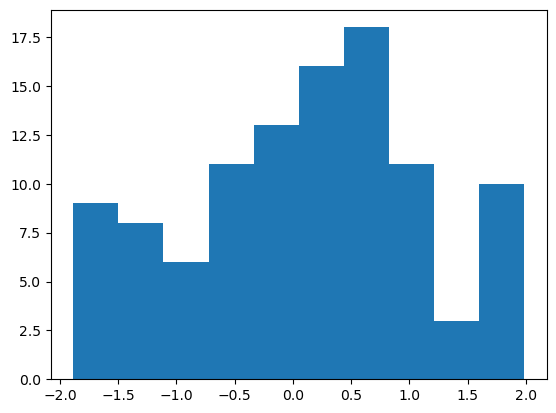

In [10]:
plt.hist(y_test_trans_scale)

# linear

ValueError: Input contains NaN.

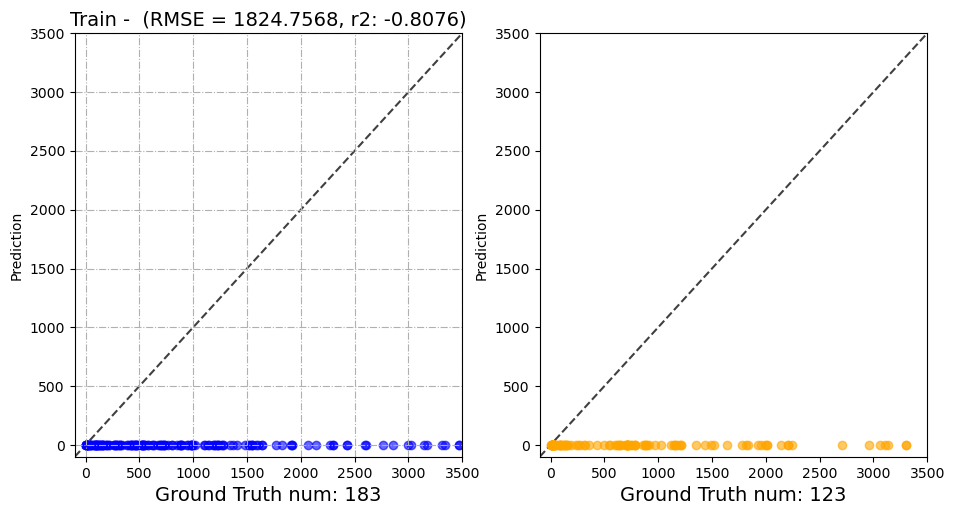

In [60]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_trans_scale)

y_pred_train = inverse_trans(model.predict(X_train_scaled),lambda_used)
y_pred_test = inverse_trans(model.predict(X_test_scaled),lambda_used)

# model.fit(X_train_scaled, y_train)

# y_pred_train = model.predict(X_train_scaled)
# y_pred_test = model.predict(X_test_scaled)

fig,ax = plt.subplots(1,2,figsize=(11, 5.5))
names = ""
myplots(ax,[y_train,y_test],[y_pred_train,y_pred_test],[0,0],
           ["Train - "+names,"Test - "+names],[-100,3500])

# ridge

In [ ]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_scaled, y_train)

y_pred_train = ridge.predict(X_train_scaled)
y_pred_test = ridge.predict(X_test_scaled)

fig,ax = plt.subplots(1,2,figsize=(11, 5.5))
names = df.columns[-1]
myplots(ax,[y_train,y_test],[y_pred_train,y_pred_test],[0,0],
           ["Train - "+names,"Test - "+names],[-100,3000])

# xgboost

In [56]:
X_train_scaled.shape

(157, 61)

In [57]:
dtrain_trans_scale = xgb.DMatrix(X_train_scaled, label=y_train_trans_scale)
dtest_trans_scale = xgb.DMatrix(X_test_scaled, label=y_test_trans_scale)

# dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
# dtest = xgb.DMatrix(X_test_scaled, label=y_test)

In [37]:
train_feat = np.concatenate([X_train_scaled, X_test_scaled],axis=0)
train_label = np.concatenate([y_train_trans_scale, y_test_trans_scale],axis=0)

dtrain = xgb.DMatrix(train_feat, label=train_label)

In [59]:
def objective(trial):
    # 定义参数空间
    params = {
        'objective': 'reg:squarederror',  # 回归任务的损失函数
        'eval_metric': 'rmse',  # 评估指标为均方根误差
        'booster': 'gbtree',  # 使用基于树的模型
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # L2 正则化
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),  # L1 正则化
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # 树的最大深度，范围适中以避免过拟合
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),  # 学习率，聚焦常用范围
        'gamma': trial.suggest_float('gamma', 1e-4, 1.0, log=True),  # 最小损失减少量，较小范围更适合回归
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 子采样比例
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 特征采样比例
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # 最小子节点权重
        'tree_method': 'auto',  # 自动选择最优的树构建方法
        'grow_policy': 'depthwise',  # 树生长策略
        'seed': 42,  # 固定随机种子以保证可重复性
    }

    # 训练模型
    m = xgb.train(
        params,
        dtrain_trans_scale,
        evals=[(dtrain_trans_scale, 'train'), (dtest_trans_scale, 'valid')],
        num_boost_round=50,
        early_stopping_rounds=5,
        verbose_eval=False  # 避免过多日志输出
    )
    
    # 预测并计算 R² 分数
    y_pred = m.predict(dtrain)
    loss = MAE(train_label, y_pred) #r2_score
    return loss

# 创建并运行 Optuna 优化
study = optuna.create_study(direction='minimize')  # 最大化 R² 分数 maximize
study.optimize(objective, n_trials=2000, n_jobs=1)

# 输出最佳参数
print("Best parameters:", study.best_trial.params)
print("Best R² score:", study.best_trial.value)

[I 2025-09-10 19:58:15,673] A new study created in memory with name: no-name-90dd2cfd-43e1-4996-9b09-6be602a42013
[I 2025-09-10 19:58:15,816] Trial 0 finished with value: 0.5920350468091021 and parameters: {'lambda': 1.3875485797604936e-08, 'alpha': 5.622791977400874e-07, 'max_depth': 7, 'eta': 0.044497266714451124, 'gamma': 0.3045702201054639, 'subsample': 0.5822449103734355, 'colsample_bytree': 0.5699788860963, 'min_child_weight': 5}. Best is trial 0 with value: 0.5920350468091021.
[I 2025-09-10 19:58:15,894] Trial 1 finished with value: 0.6222526201203747 and parameters: {'lambda': 3.634706075267934e-07, 'alpha': 9.803163801487358e-08, 'max_depth': 3, 'eta': 0.08021912570283145, 'gamma': 0.03350832056460904, 'subsample': 0.5748714172074452, 'colsample_bytree': 0.629392136659717, 'min_child_weight': 8}. Best is trial 0 with value: 0.5920350468091021.
[I 2025-09-10 19:58:16,187] Trial 2 finished with value: 0.6780570669371495 and parameters: {'lambda': 5.5089106464238356e-06, 'alpha':

Best parameters: {'lambda': 5.9980380129308895e-06, 'alpha': 0.03758370653660196, 'max_depth': 10, 'eta': 0.27026588962265174, 'gamma': 0.00010012218361877874, 'subsample': 0.9726024497438529, 'colsample_bytree': 0.8396627408640177, 'min_child_weight': 2}
Best R² score: 0.3005838217569659


In [16]:
study.best_trial.params # 0.339379055670502

{'lambda': 3.018998916838588e-08,
 'alpha': 0.0010959825343935593,
 'max_depth': 10,
 'eta': 0.26103525997082505,
 'gamma': 0.009223036304079703,
 'subsample': 0.9763972216834321,
 'colsample_bytree': 0.5002883766228616,
 'min_child_weight': 2}

In [38]:
# mix&single
best_param = {
    'objective': 'reg:squarederror',  # 回归任务的损失函数
        'eval_metric': 'rmse',  # 评估指标为均方根误差
    'tree_method': 'auto',  # 自动选择最优的树构建方法
        'grow_policy': 'depthwise',  # 树生长策略
        'seed': 42,  # 固定随机种子以保证可重复性
    'booster': 'gbtree',
    'lambda': 6.332812169715322e-06,
 'alpha': 2.0699880090622165e-07,
 'max_depth': 4,
 'eta': 0.08449639234335357,
 'gamma': 0.0005224847536617888,
 'subsample': 0.5417028276049611,
 'colsample_bytree': 0.9574953068162031,
 'min_child_weight': 1}

#mix
# best_param = {
#     'objective': 'reg:squarederror',  # 回归任务的损失函数
#         'eval_metric': 'rmse',  # 评估指标为均方根误差
#     'tree_method': 'auto',  # 自动选择最优的树构建方法
#         'grow_policy': 'depthwise',  # 树生长策略
#         'seed': 42,  # 固定随机种子以保证可重复性
#     'booster': 'gbtree',
#     'lambda': 8.443214519351591e-08,
#  'alpha': 7.599912011961461e-07,
#  'max_depth': 3,
#  'eta': 0.052991648638215864,
#  'gamma': 0.3933934866416587,
#  'subsample': 0.5937176513932294,
#  'colsample_bytree': 0.8219127364732578,
#  'min_child_weight': 5}

# validation
evals_result = {}

# final_model = xgb.train( best_param, dtrain_model, evals = [(dtrain_model, 'train'), (dtest_model, 'valid')] ,verbose_eval=False, evals_result=evals_result,num_boost_round =400)
 
# train_test_err = np.array(evals_result['train']['rmse']) - np.array(evals_result['valid']['rmse'])
# FoM_t = abs(train_test_err)+np.array(evals_result['valid']['rmse'])
# FoM = np.array([10e3 if train_test_err[i]>0.001 else FoM_t[i] for i in range(len(train_test_err))])
# best_epoch = np.argmin(FoM)+1

xgb_train = dtrain#dtrain_trans_scale
xgb_test = dtest_trans_scale

final_model = xgb.train(
        best_param,
        dtrain,
        evals=[(dtrain, 'train'), (dtest_trans_scale, 'valid')],
        num_boost_round=100,
        early_stopping_rounds=5,
        verbose_eval=True  # 避免过多日志输出
    )

# y_pred_train = inverse_trans(final_model.predict(xgb_train),lambda_used)
# y_pred_test = inverse_trans(final_model.predict(xgb_test),lambda_used)
y_pred_train = final_model.predict(dtrain_trans_scale)
y_pred_test = final_model.predict(dtest_trans_scale)

y_pred_train_orin = inverse_trans(y_scaler.inverse_transform(y_pred_train.reshape(-1,1)).reshape(-1),lambda_used)
y_pred_test_orin = inverse_trans(y_scaler.inverse_transform(y_pred_test.reshape(-1,1)).reshape(-1),lambda_used)

[0]	train-rmse:0.97245	valid-rmse:0.96950
[1]	train-rmse:0.94292	valid-rmse:0.93294
[2]	train-rmse:0.91221	valid-rmse:0.89883
[3]	train-rmse:0.88680	valid-rmse:0.87471
[4]	train-rmse:0.85852	valid-rmse:0.84817
[5]	train-rmse:0.83115	valid-rmse:0.82022
[6]	train-rmse:0.81346	valid-rmse:0.80162
[7]	train-rmse:0.79878	valid-rmse:0.78683
[8]	train-rmse:0.78211	valid-rmse:0.77471
[9]	train-rmse:0.77004	valid-rmse:0.75888
[10]	train-rmse:0.75908	valid-rmse:0.74934
[11]	train-rmse:0.74655	valid-rmse:0.74275
[12]	train-rmse:0.73358	valid-rmse:0.72681
[13]	train-rmse:0.72006	valid-rmse:0.71576
[14]	train-rmse:0.71040	valid-rmse:0.70759
[15]	train-rmse:0.69446	valid-rmse:0.68174
[16]	train-rmse:0.67808	valid-rmse:0.66160
[17]	train-rmse:0.66871	valid-rmse:0.65202
[18]	train-rmse:0.65798	valid-rmse:0.63597
[19]	train-rmse:0.64532	valid-rmse:0.62505
[20]	train-rmse:0.63876	valid-rmse:0.61616
[21]	train-rmse:0.63169	valid-rmse:0.61150
[22]	train-rmse:0.62289	valid-rmse:0.60952
[23]	train-rmse:0.616

In [39]:
y_pred_train.shape

(157,)

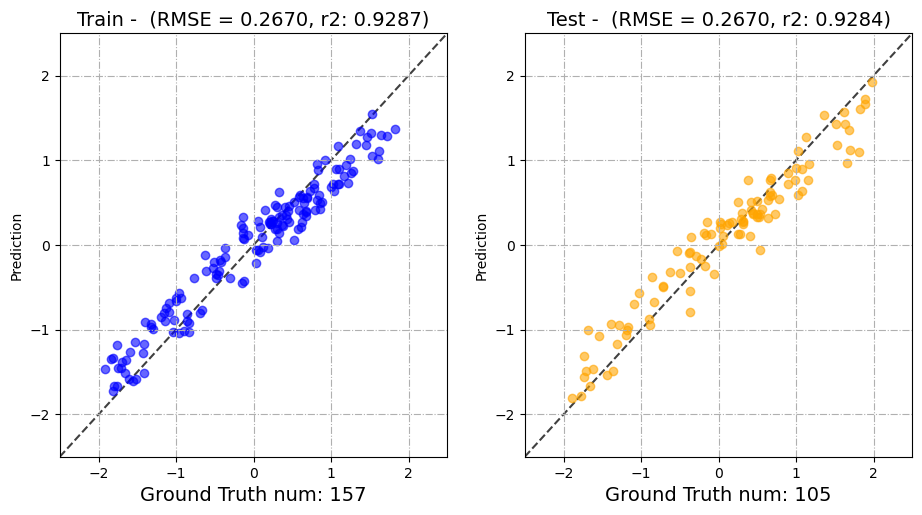

In [40]:
fig,ax = plt.subplots(1,2,figsize=(11, 5.5))
names = ""
myplots(ax,[y_train_trans_scale,y_test_trans_scale],[y_pred_train,y_pred_test],[0,0],
           ["Train - "+names,"Test - "+names],[-2.5,2.5])

In [30]:
fig,ax = plt.subplots(1,1,figsize=(5.5, 5.5))
names = df.columns[-1]
myplots([ax,ax],[y_train_trans_scale,y_test_trans_scale],[y_pred_train,y_pred_test],[0,0],
           ["Train - "+names,"Test - "+names],[-2.5,2.5])

fig.savefig('mix&single.png', dpi=300, bbox_inches='tight')  
plt.close()  # 关闭当前图，以释放内存 

In [13]:
y_train_trans_scale.shape

(230, 1)

In [41]:
ML_result1 = pd.DataFrame({
    # 'train_orin':y_train,
    # 'y_pred_train_orin':y_pred_train_orin,
    'train_scale':y_train_trans_scale.reshape(-1),
    'y_pred_train_scale':y_pred_train.reshape(-1),
})

ML_result2 = pd.DataFrame({
    # 'test_orin':y_test,
    # 'y_pred_test_orin':y_pred_test_orin,
    'test_scale':y_test_trans_scale.reshape(-1),
    'y_pred_test_scale':y_pred_test.reshape(-1)
})

excel_file = 'Mix_ML_results_T80.xlsx'  

# 使用 ExcelWriter 将两个 DataFrame 写入不同的 sheet  
with pd.ExcelWriter(excel_file) as writer:  
    ML_result1.to_excel(writer, sheet_name='Sheet1', index=False)  # 第一个 DataFrame 写入 Sheet1  
    ML_result2.to_excel(writer, sheet_name='Sheet2', index=False)  # 第二个 DataFrame 写入 Sheet2  

print(f"DataFrames have been written to {excel_file} in different sheets.")  

DataFrames have been written to Mix_ML_results_T80.xlsx in different sheets.


In [27]:
fig,ax = plt.subplots(1,1,figsize=(5.5, 5.5))
names = df.columns[-1]
myplots([ax,ax],[y_train,y_test],[y_pred_train_orin,y_pred_test_orin],[0,0],
           ["Train - "+names,"Test - "+names],[-100,2500])

fig.savefig('XGB.png', dpi=300, bbox_inches='tight')  
plt.close()  # 关闭当前图，以释放内存 

In [69]:
y_pred = final_model.predict(all_data)

y_pred_train_orin = inverse_trans(y_scaler.inverse_transform(y_pred.reshape(-1,1)).reshape(-1),lambda_used)

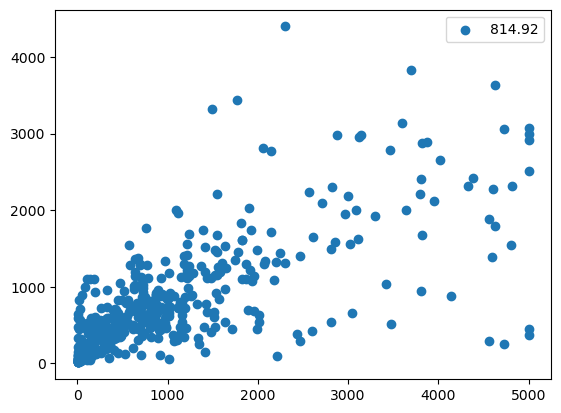

In [71]:
metric = RMSE(data.values[:,-1],y_pred_train_orin)
plt.scatter(data.values[:,-1],y_pred_train_orin,label=f"{metric:.2f}")
plt.legend()

In [73]:
data['error'] = np.abs(data['Abs-T80'] - y_pred_train_orin)

In [75]:
data.to_excel("exp_with_error.xlsx")

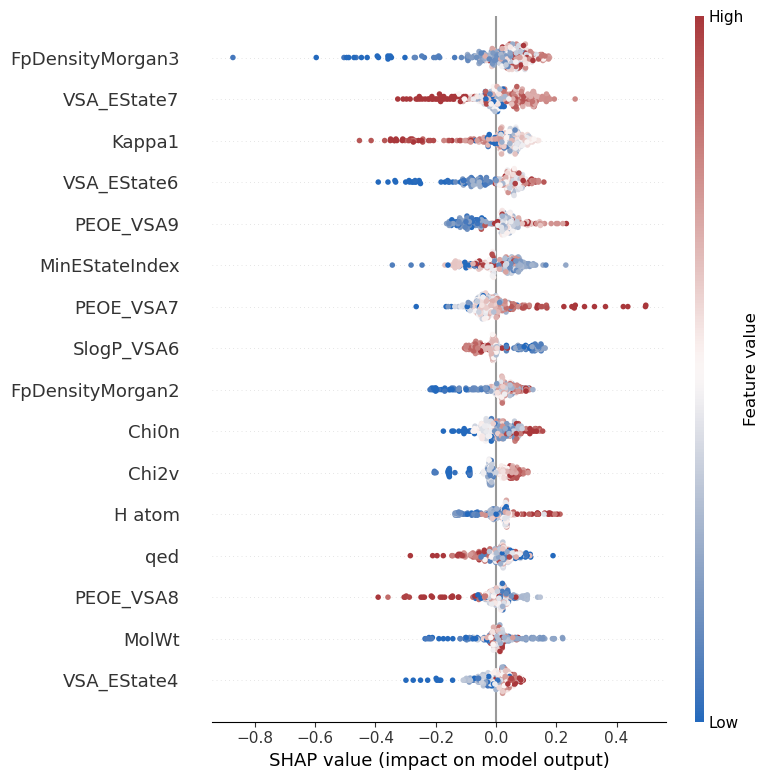

In [42]:
import shap
import seaborn as sns

all_data_x = np.concatenate([X_train_scaled, X_test_scaled],axis=0)
# 创建一个 SHAP 值解释器  
explainer = shap.Explainer(final_model,all_data_x)  

shap_data = all_data_x#.iloc[np.where(data['FWHM_top_1']<90)[0],:-1]
# norm_params = scaler_label.transform(shap_data.values)  #group_params[0])

# df_data = pd.DataFrame(norm_params,columns = shap_data.columns)
# 计算 SHAP 值
shap_values = explainer(shap_data)  

# 可视化 SHAP 值  
fig = plt.figure()
cmap = sns.color_palette("vlag", as_cmap=True) 
shap.summary_plot(shap_values, shap_data, max_display=16,cmap=cmap,feature_names=data.keys())  
fig.savefig('Mix_shap_summary_plot_T80_XGB.png', dpi=300, bbox_inches='tight')  
plt.close()  # 关闭当前图，以释放内存 

# LIGHTGBM

In [44]:
import lightgbm as lgb

In [92]:
study.best_params

{'num_leaves': 36,
 'max_depth': 11,
 'learning_rate': 0.1382577374172062,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.7000000000000001,
 'bagging_freq': 1,
 'lambda_l1': 6.479744339941062e-07,
 'lambda_l2': 0.061716856317840456,
 'min_data_in_leaf': 20}

In [50]:
params = {'num_leaves': 36,
 'max_depth': 11,
 'learning_rate': 0.1382577374172062,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.7000000000000001,
 'bagging_freq': 1,
 'lambda_l1': 6.479744339941062e-07,
 'lambda_l2': 0.061716856317840456,
 'min_data_in_leaf': 10}

train_data = lgb.Dataset(X_train_scaled, label=y_train_trans_scale)
valid_data = lgb.Dataset(X_test_scaled, label=y_test_trans_scale, reference=train_data)
bst = lgb.train(params, train_data,valid_sets=valid_data,num_boost_round =10)

y_pred_train = bst.predict(X_train_scaled)
y_pred_test = bst.predict(X_test_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2381
[LightGBM] [Info] Number of data points in the train set: 157, number of used features: 61
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

D:\Anaconda\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


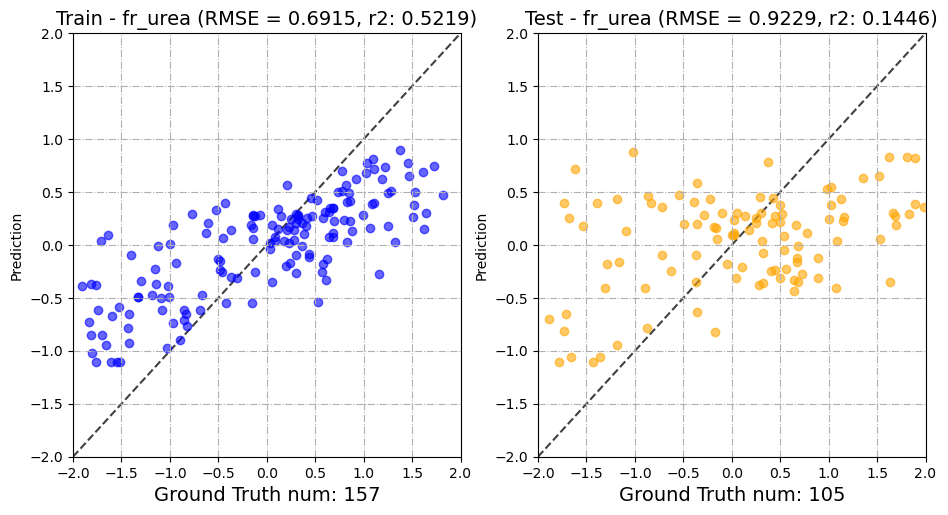

In [51]:
fig,ax = plt.subplots(1,2,figsize=(11, 5.5))
names = df.columns[-1]
myplots(ax,[y_train_trans_scale,y_test_trans_scale],[y_pred_train,y_pred_test],[0,0],
           ["Train - "+names,"Test - "+names],[-2,2])

# random forest

In [54]:
train_rf = X_train_scaled
test_rf = X_test_scaled

def objective(trial):  
    # 参数选择部分, 针对随机森林
    params = {    
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # 树的数量
        'max_depth': trial.suggest_int('max_depth', 5, 20),  # 最大深度
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),  # 分裂时的最小样本数
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),  # 叶子节点最小样本数
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),  # 最大特征数
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),  # 是否使用bootstrap
        'random_state': 42  # 随机种子
    }

    # 训练随机森林模型
    rf = RandomForestRegressor(**params)

    # 拟合模型
    rf.fit(train_rf, y_train)

    # 计算RMSE
    y_pred_train = rf.predict(train_rf)
    y_pred_test = rf.predict(test_rf)

    # 计算RMSE（训练和验证）
    train_rmse = np.sqrt(RMSE(y_train, y_pred_train))
    test_rmse = np.sqrt(RMSE(y_test, y_pred_test))

    # 使用test RMSE作为目标
    return test_rmse

# 创建一个Optuna study来优化参数
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=300)

# 打印最优参数
# print('Best trial:', study.best_trial.params)

# 使用最优参数训练最终模型
best_params = {'n_estimators': 430,
 'max_depth': 15,
 'min_samples_split': 17,
 'min_samples_leaf': 14,
 'max_features': 'log2',
 'bootstrap': True}
final_rf = RandomForestRegressor(**best_params)

# 训练最终模型
final_rf.fit(train_rf, y_train_trans_scale)

# 使用训练好的模型进行预测
y_pred_train_final = final_rf.predict(train_rf)
y_pred_test_final = final_rf.predict(test_rf)

D:\Anaconda\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


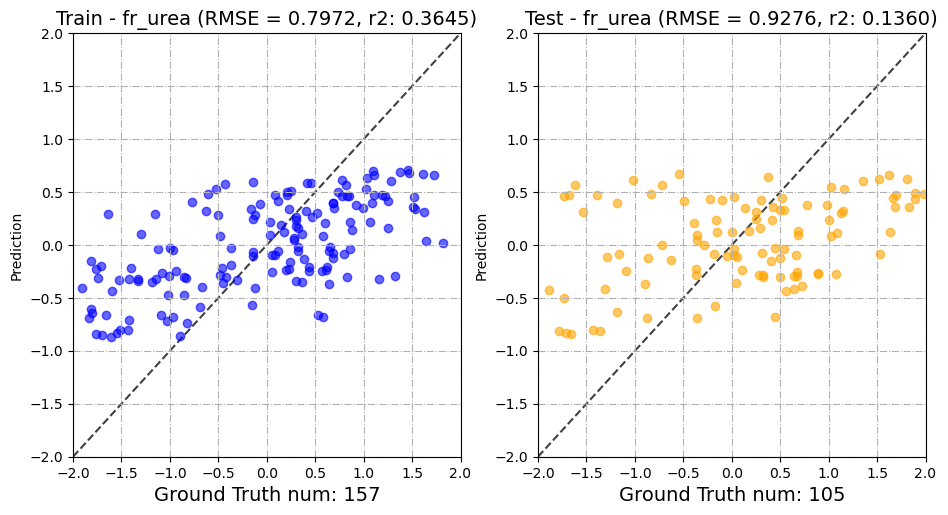

In [55]:
fig,ax = plt.subplots(1,2,figsize=(11, 5.5))
names = df.columns[-1]
myplots(ax,[y_train_trans_scale,y_test_trans_scale],[y_pred_train_final,y_pred_test_final],[0,0],
           ["Train - "+names,"Test - "+names],[-2,2])

# nn

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 定义三层全连接神经网络
class ThreeLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ThreeLayerNN, self).__init__()
        # 定义网络层
        self.fc1 = nn.Linear(input_size, hidden_size)  # 第一层（输入到隐藏层）
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # 第二层（隐藏层到隐藏层）
        self.fc3 = nn.Linear(hidden_size, output_size)  # 第三层（隐藏层到输出层）
        self.relu = nn.ReLU()  # 激活函数ReLU

    def forward(self, x):
        # 定义前向传播
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


def set_seed(seed):
    # 设置 Python 的随机种子
    random.seed(seed)

    # 设置 NumPy 的随机种子
    np.random.seed(seed)

    # 设置 PyTorch CPU 的随机种子
    torch.manual_seed(seed)


def train(model, data, criterion, optimizer,epoch):

    X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = data
    # 训练模型
    num_epochs = epoch
    batch_size = 12
    patience = 20  # 设定耐心值（如果验证集的损失在连续10个epoch内没有改善，则停止训练）
    best_valid_loss = float('inf')  # 初始化最小验证损失为无穷大
    patience_counter = 0  # 用来计数没有改善的epoch数量
    loss_list = []
    val_list = []
    for epoch in range(num_epochs):
        model.train()  # 设置为训练模式
        permutation = torch.randperm(X_train_tensor.size(0))  # 随机打乱数据
        epoch_loss = 0
        
        for i in range(0, X_train_tensor.size(0), batch_size):
            # 获取一个batch的数据
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
    
            # 前向传播
            outputs = model(batch_x)
            
            # 计算损失
            loss = criterion(outputs, batch_y)
            
            # 反向传播
            optimizer.zero_grad()  # 清空之前的梯度
            loss.backward()  # 计算梯度
            optimizer.step()  # 更新权重
    
            epoch_loss += loss.item()
    
        loss_list.append(epoch_loss / len(X_train_tensor))
    
        # 计算在验证集上的损失
        model.eval()  # 设置为评估模式
        with torch.no_grad():  # 关闭梯度计算
            valid_outputs = model(X_test_tensor)
            valid_loss = nn.MSELoss()(valid_outputs, y_test_tensor)
    
        val_list.append(valid_loss.item())
    
        print(f"Epoch [{epoch+1:3}/{num_epochs:3}], "
          f"Train Loss: {epoch_loss / len(X_train_tensor):.3f}, "
          f"Validation Loss: {valid_loss.item():<.3f}")
    
    # 评估模型
    model.eval()  # 设置为评估模式
    with torch.no_grad():  # 关闭梯度计算
        y_pred_train_trans_norm = model(X_train_tensor).numpy()
        y_pred_test_trans_norm = model(X_test_tensor).numpy()
    
        y_pred_train = inverse_trans(y_scaler.inverse_transform(y_pred_train_trans_norm),lambda_used)
        y_pred_test = inverse_trans(y_scaler.inverse_transform(y_pred_test_trans_norm),lambda_used)

    return loss_list, val_list, [y_pred_train_trans_norm,y_pred_test_trans_norm,y_pred_train,y_pred_test]

